In [1]:
import pandas as pd 
import glob
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.impute import IterativeImputer

In [2]:
file_pattern = "ROR*.WTH"
all_files = glob.glob(file_pattern)

all_files

['ROR15901.WTH',
 'ROR16001.WTH',
 'ROR16101.WTH',
 'ROR16201.WTH',
 'ROR16301.WTH',
 'ROR16401.WTH',
 'ROR16501.WTH',
 'ROR16601.WTH',
 'ROR16701.WTH',
 'ROR16801.WTH',
 'ROR16901.WTH',
 'ROR17001.WTH',
 'ROR17101.WTH',
 'ROR17201.WTH',
 'ROR17301.WTH',
 'ROR17401.WTH',
 'ROR17501.WTH',
 'ROR17601.WTH',
 'ROR17701.WTH',
 'ROR17801.WTH',
 'ROR17901.WTH',
 'ROR18001.WTH',
 'ROR18101.WTH',
 'ROR18201.WTH',
 'ROR18301.WTH',
 'ROR18401.WTH',
 'ROR18501.WTH',
 'ROR18601.WTH',
 'ROR18701.WTH',
 'ROR18801.WTH',
 'ROR18901.WTH',
 'ROR19001.WTH',
 'ROR19101.WTH',
 'ROR19201.WTH',
 'ROR19301.WTH',
 'ROR19401.WTH',
 'ROR19501.WTH',
 'ROR19601.WTH',
 'ROR19701.WTH',
 'ROR19801.WTH',
 'ROR19901.WTH']

In [3]:
file_pattern = "ROR*.WTH"
all_files = glob.glob(file_pattern)

data_frames = []

for file in all_files:
    df = pd.read_csv(file, delim_whitespace=True, skiprows=5, names=['@DATE', 'SRAD', 'TMAX', 'TMIN', 'RAIN'])
    data_frames.append(df)
    
merged_data = pd.concat(data_frames, ignore_index=True)

merged_data

,@DATE,SRAD,TMAX,TMIN,RAIN
0,59001,0.9,9.5,2.2,0.5
1,59002,3.3,10.5,1.0,1.0
2,59003,0.7,11.4,0.9,21.1
3,59004,3.1,12.3,8.7,3.7
4,59005,0.9,12.7,5.0,0.4
...,...,...,...,...,...
14970,99361,1.5,2.8,0.6,0.0
14971,99362,0.7,3.1,1.0,0.0
14972,99363,3.7,4.2,-0.2,1.1
14973,99364,0.5,6.1,-0.7,8.1


In [4]:
def date_converter(date):
    year = 1900 + int(str(date)[:2])
    day_of_year = int(str(date)[2:])
    return pd.Timestamp(year, 1, 1) + pd.Timedelta(days=day_of_year - 1)

merged_data['@DATE'] = merged_data['@DATE'].apply(date_converter)

merged_data.set_index('@DATE', inplace=True)

merged_data

,SRAD,TMAX,TMIN,RAIN
@DATE,,,,
1959-01-01,0.9,9.5,2.2,0.5
1959-01-02,3.3,10.5,1.0,1.0
1959-01-03,0.7,11.4,0.9,21.1
1959-01-04,3.1,12.3,8.7,3.7
1959-01-05,0.9,12.7,5.0,0.4
...,...,...,...,...
1999-12-27,1.5,2.8,0.6,0.0
1999-12-28,0.7,3.1,1.0,0.0
1999-12-29,3.7,4.2,-0.2,1.1


In [5]:
def aggregate_data(df, freq='M'):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    aggregated_df = df.resample(freq).agg({
        'SRAD': 'mean',
        'TMAX': 'mean',  
        'TMIN': 'mean', 
        'RAIN': 'mean' 
    })
    
    if freq == 'M':
        aggregated_df.index = aggregated_df.index.to_period('M')
        
    return aggregated_df


data = aggregate_data(merged_data, freq='W')

data


,SRAD,TMAX,TMIN,RAIN
@DATE,,,,
1959-01-04,2.000000,10.925000,3.200000,6.575000
1959-01-11,2.042857,9.914286,4.271429,1.100000
1959-01-18,2.385714,8.371429,4.085714,1.385714
1959-01-25,2.771429,6.271429,0.742857,0.628571
1959-02-01,2.528571,8.800000,3.085714,3.042857
...,...,...,...,...
1999-12-05,2.428571,9.714286,2.800000,1.085714
1999-12-12,1.614286,9.500000,4.114286,3.157143
1999-12-19,2.157143,4.828571,-0.242857,1.671429


## Monthly Average Visualization

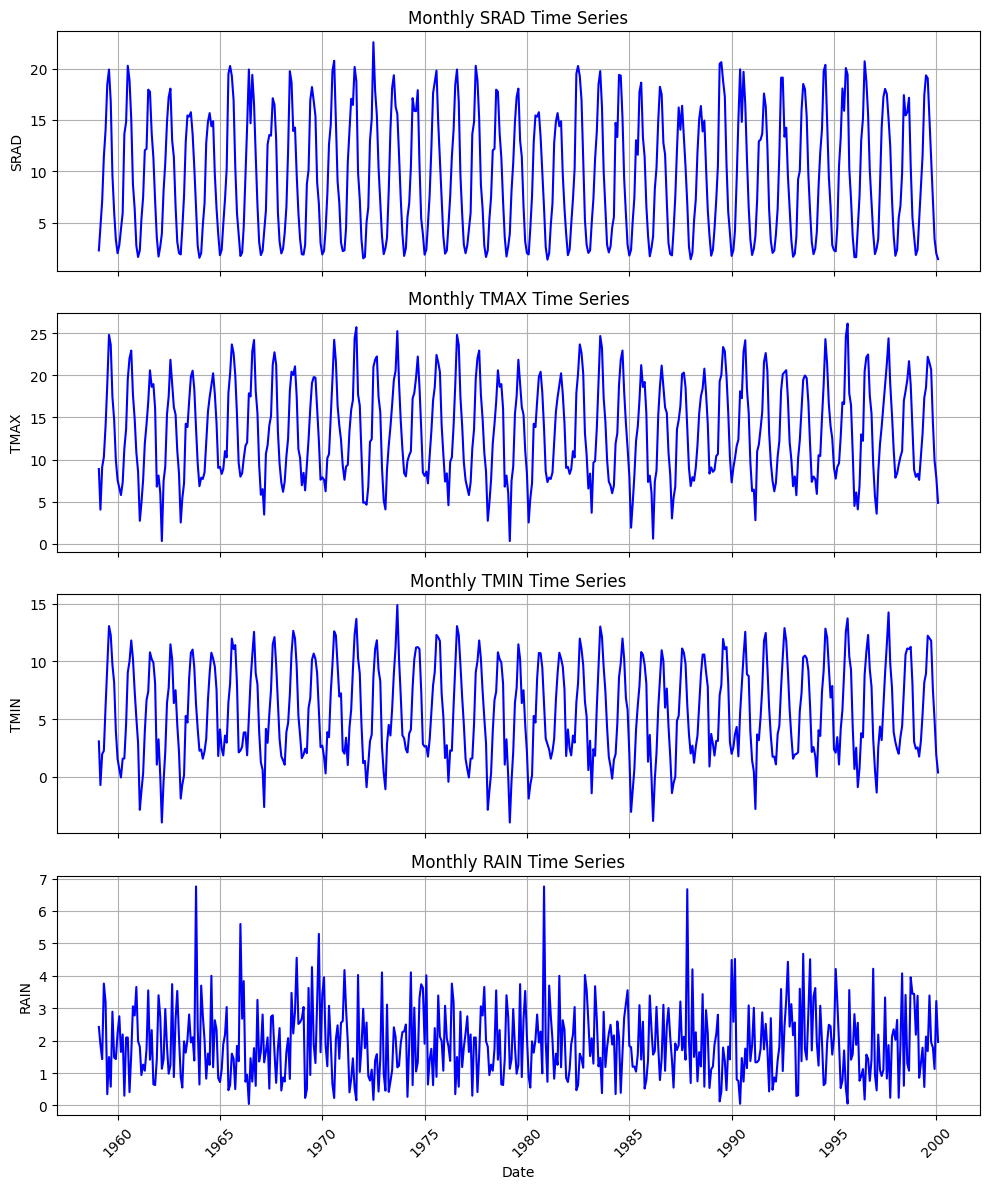

In [6]:
df = data.copy()

monthly_df = df.resample('M').mean()

# Plotting the time series
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each variable
for i, column in enumerate(monthly_df.columns):
    axs[i].plot(monthly_df.index, monthly_df[column], label=column, color='b')
    axs[i].set_title(f'Monthly {column} Time Series')
    axs[i].set_ylabel(column)
    axs[i].grid(True)

# Shared x-axis label
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Histogram Visualization

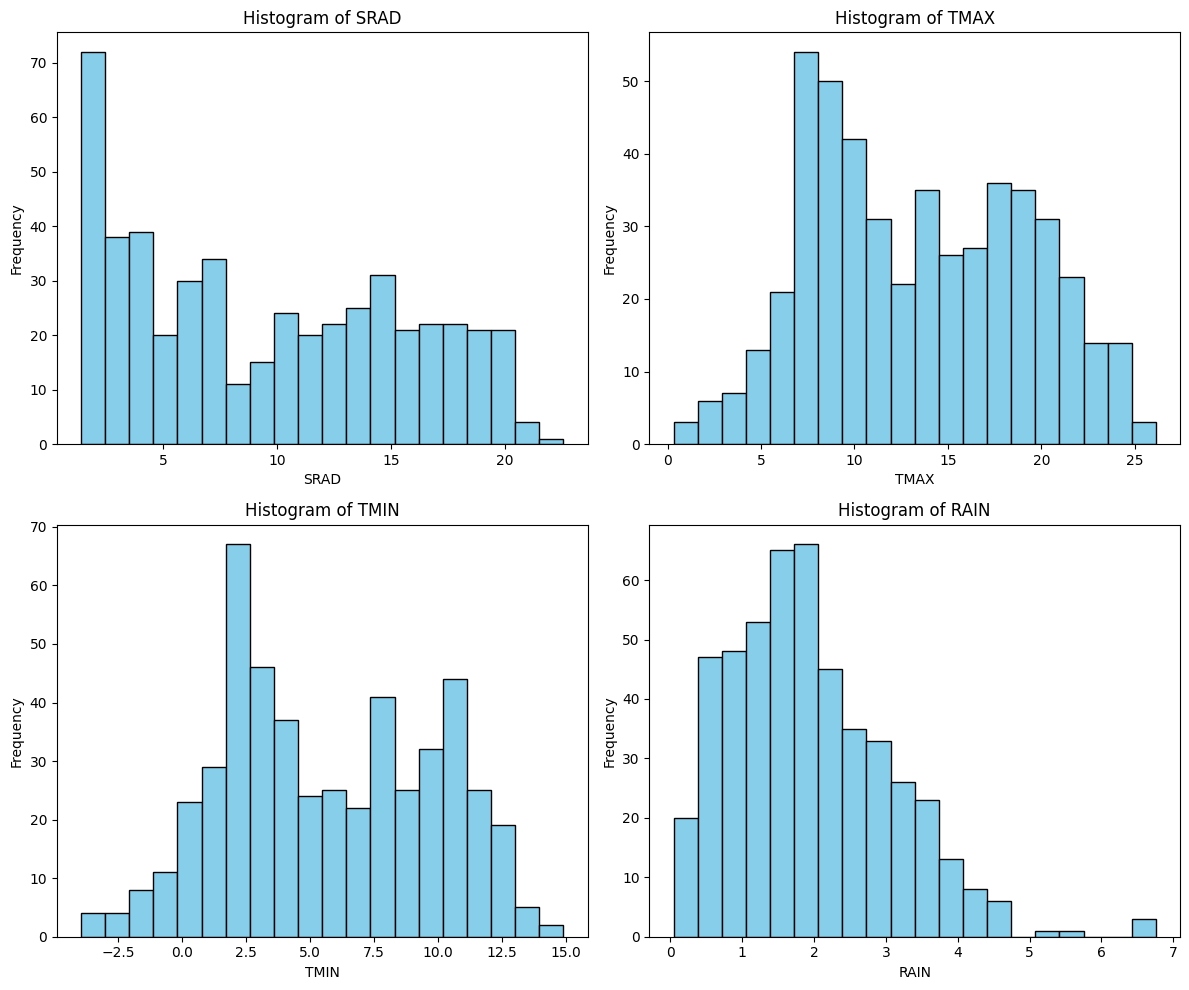

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the 2x2 grid for easy iteration
axs = axs.flatten()

# Plot a histogram for each variable
for i, column in enumerate(monthly_df.columns):
    axs[i].hist(monthly_df[column], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Handling Missing Value

In [8]:
merged_data.isna().sum()

SRAD    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

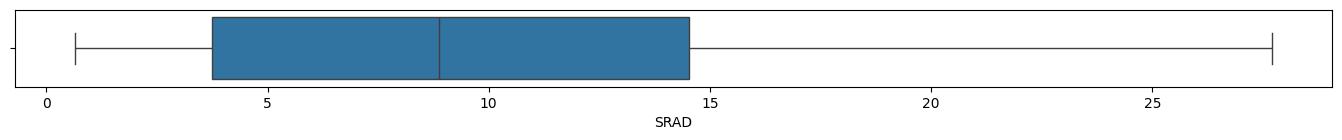

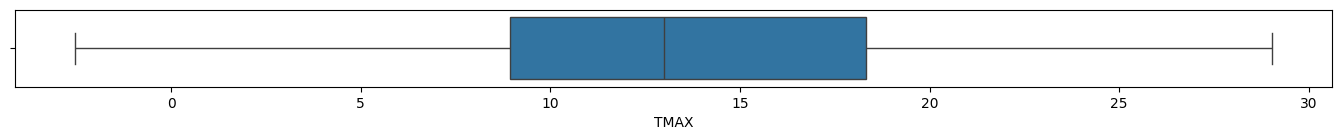

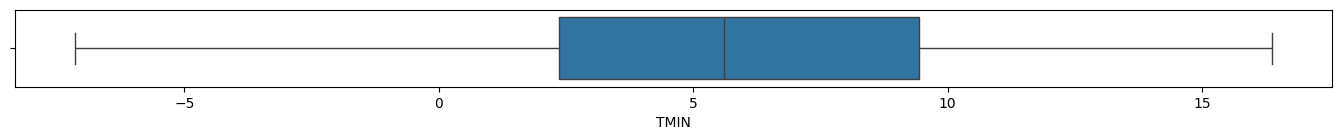

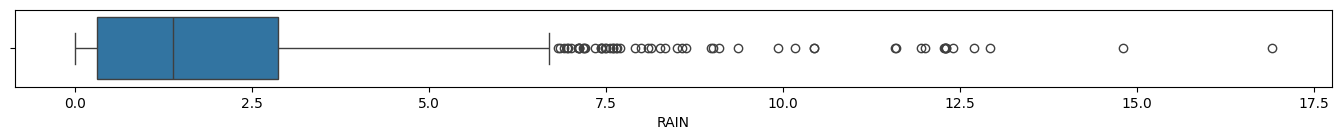

In [9]:
for i in data:
    plt.figure(figsize = (17,1))
    sns.boxplot(data, x = i)

In [10]:
def handle_outliers_iqr(data, columns, k=3, method='cap'):
    for column in columns:
        if column == "RAIN":
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3 - q1

            lower_bound = q1 - k * iqr
            upper_bound = 10

            if method == 'remove':
                data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
            elif method == 'cap':
                data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
            elif method == 'transform':
                data[column] = data[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
                
        else:
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3 - q1

            lower_bound = q1 - k * iqr
            upper_bound = q3 + k * iqr

            if method == 'remove':
                data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
            elif method == 'cap':
                data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
            elif method == 'transform':
                data[column] = data[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
                
            

    return data

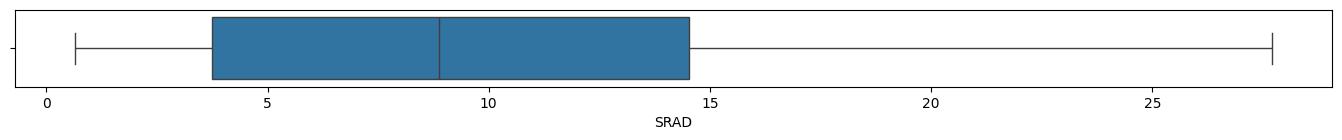

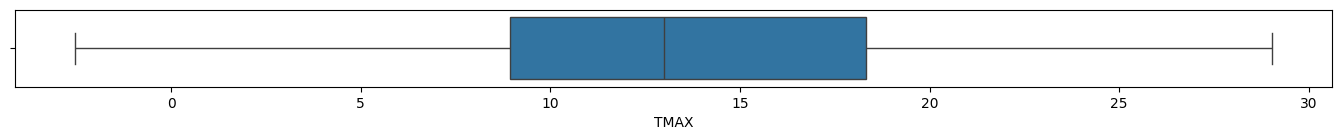

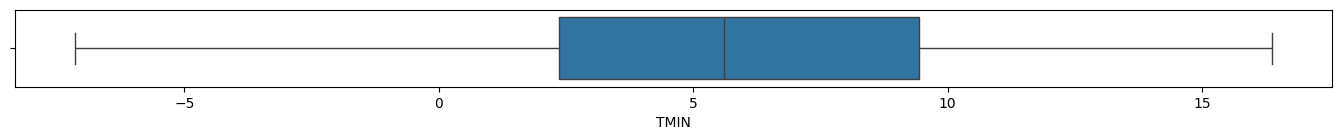

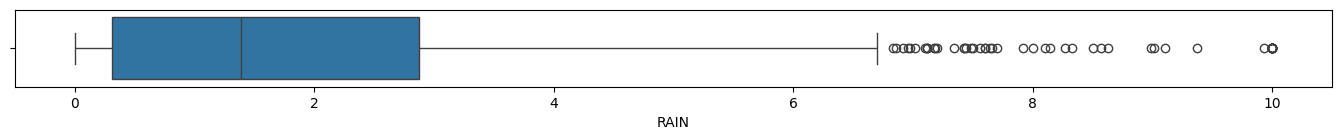

In [11]:
final_data = data.copy()
final_data = handle_outliers_iqr(data, ['SRAD','RAIN','TMIN','TMAX'],method='cap')

for i in final_data:
    plt.figure(figsize = (17,1))
    sns.boxplot(final_data, x = i)

In [12]:
final_data = final_data.reset_index()

In [13]:
final_data["week"] = final_data["@DATE"].dt.isocalendar().week.astype("int")
final_data["year"] = final_data["@DATE"].dt.isocalendar().year.astype("int")

In [14]:
final_data

,@DATE,SRAD,TMAX,TMIN,RAIN,week,year
0,1959-01-04,2.000000,10.925000,3.200000,6.575000,1,1959
1,1959-01-11,2.042857,9.914286,4.271429,1.100000,2,1959
2,1959-01-18,2.385714,8.371429,4.085714,1.385714,3,1959
3,1959-01-25,2.771429,6.271429,0.742857,0.628571,4,1959
4,1959-02-01,2.528571,8.800000,3.085714,3.042857,5,1959
...,...,...,...,...,...,...,...
2135,1999-12-05,2.428571,9.714286,2.800000,1.085714,48,1999
2136,1999-12-12,1.614286,9.500000,4.114286,3.157143,49,1999
2137,1999-12-19,2.157143,4.828571,-0.242857,1.671429,50,1999
2138,1999-12-26,1.757143,7.471429,0.728571,6.971429,51,1999


## Dataset Splitting and Scalling

In [15]:
#LSTM
def create_model(optimizer='adam', units=50, activation='relu'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [16]:
start = 26
target = "SRAD"

result_predictions_knn = []
result_predictions_rf = []
result_predictions_xgb = []
result_predictions_ada = []
result_predictions_mlp = []
result_predictions_lstm = []
result_predictions_voting = []
result_predictions_stacking = []

for i in range(0,start+1):    
    x_train = final_data.iloc[i:len(final_data)-start+i, :]
    y_train = x_train[target]
    x_train = x_train.drop(columns=[target, "@DATE"])
    x_test = final_data.iloc[len(final_data)-start+i:, :]
    y_test = x_test[target]
    x_test = x_test.drop(columns=[target, "@DATE"])
    X_train_scaled = x_train.copy()
    X_test_scaled = x_test.copy().head(1)
    scaler = StandardScaler()
    if X_test_scaled.shape[0] == 0:
        print(f"Skipping iteration {i} because x_test is empty.")
        continue
    X_train_scaled = scaler.fit_transform(X_train_scaled)
    X_test_scaled = scaler.transform(X_test_scaled)
    
    param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 50],
    'p': [1, 2]
    }

    knn_regressor = KNeighborsRegressor()
    grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)

    best_knn_regressor = grid_search.best_estimator_
    predictions_knn = best_knn_regressor.predict(X_test_scaled)
    predictions_knn = predictions_knn.tolist()[0]
    result_predictions_knn.append(predictions_knn)
    
    param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [10,  None],
    'min_samples_leaf': [1, 4]
    }

    rf_regressor = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)

    # Use the best estimator to make predictions
    best_rf_regressor = grid_search.best_estimator_
    predictions_rf = best_rf_regressor.predict(X_test_scaled)
    predictions_rf = predictions_rf.tolist()[0]
    result_predictions_rf.append(predictions_rf)
    
    param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, None],
    'subsample': [0.8, 1.0]
    }


    xgb_regressor = XGBRegressor(random_state=42)


    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


    grid_search.fit(X_train_scaled, y_train)


    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)
    best_xgb_regressor = grid_search.best_estimator_
    predictions_xgb = best_xgb_regressor.predict(X_test_scaled)
    predictions_xgb = predictions_xgb.tolist()[0]
    result_predictions_xgb.append(predictions_xgb)
    
    param_grid = {
    'n_estimators': [50, 500],
    'learning_rate': [0.01, 0.1],
    'loss': ['linear', 'square', 'exponential']
    }


    base_estimator = DecisionTreeRegressor(random_state=42)
    ada_regressor = AdaBoostRegressor(estimator=base_estimator, random_state=42)
    grid_search = GridSearchCV(estimator=ada_regressor, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    
    

    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)
    best_ada_regressor = grid_search.best_estimator_
    predictions_ada = best_ada_regressor.predict(X_test_scaled)
    predictions_ada = predictions_ada.tolist()[0]
    result_predictions_ada.append(predictions_ada)
    
    ## DEEP LEARNING
    param_grid = {
    'hidden_layer_sizes': [(50,50,50),(100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [200]
    }

    mlp_regressor = MLPRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)

    best_mlp_regressor = grid_search.best_estimator_
    predictions_mlp = best_mlp_regressor.predict(X_test_scaled)
    predictions_mlp = predictions_mlp.tolist()[0]
    result_predictions_mlp.append(predictions_mlp)
    
    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    model = KerasRegressor(model=create_model, batch_size = 16,epochs = 50,
                       optimizer = "adam",activation='relu',units = 50, verbose=0) 
    
    param_grid = {
    'batch_size': [16, 32],
    'epochs': [50],
    'optimizer': ['adam'],
    'units': [50, 100],
    'activation': ['relu']
    }

    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    # Fit the grid search
    grid_search.fit(X_train_reshaped, y_train)
    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)

    # Get the best model and make predictions
    best_lstm_model = grid_search.best_estimator_
    predictions_lstm = best_lstm_model.predict(X_test_reshaped)
    predictions_lstm = predictions_lstm.tolist()
    result_predictions_lstm.append(predictions_lstm)
    
    ## Hybrid Machine and Deep Learning 
    voting = VotingRegressor(
        estimators=[('knn', best_knn_regressor), ('rf', best_rf_regressor), 
                    ('xgb', best_xgb_regressor),('adb', best_ada_regressor),
                   ('mlp', best_mlp_regressor)])

    voting.fit(X_train_scaled, y_train)
    voting_prediction = voting.predict(X_test_scaled)
    predictions_voting = voting_prediction.tolist()[0]
    result_predictions_voting.append(predictions_voting)
    
    stacking = StackingRegressor(
    estimators=[('knn', best_knn_regressor), ('rf', best_rf_regressor), 
                ('xgb', best_xgb_regressor),('adb', best_ada_regressor),
               ('mlp', best_mlp_regressor)],
    final_estimator= best_rf_regressor)

    stacking.fit(X_train_scaled, y_train)
    stacking_prediction = stacking.predict(X_test_scaled)
    predictions_stacking = stacking_prediction.tolist()[0]
    result_predictions_stacking.append(predictions_stacking)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500, 'subsample': 1.0}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 50}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'units': 100}


C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Computing\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Skipping iteration 26 because x_test is empty.


## Future Data

In [17]:
final_data.head()

,@DATE,SRAD,TMAX,TMIN,RAIN,week,year
0,1959-01-04,2.000000,10.925000,3.200000,6.575000,1,1959
1,1959-01-11,2.042857,9.914286,4.271429,1.100000,2,1959
2,1959-01-18,2.385714,8.371429,4.085714,1.385714,3,1959
3,1959-01-25,2.771429,6.271429,0.742857,0.628571,4,1959
4,1959-02-01,2.528571,8.800000,3.085714,3.042857,5,1959


In [18]:
future_data = final_data.drop(columns = "@DATE").groupby(by = "week").mean().drop(columns = "year").reset_index()
future_data["year"] = 2000
future_data = future_data.drop(columns = target)
future_data = future_data.iloc[:-1:]
future_data['2_week_period'] = (future_data['week'] - 1) // 2 + 1
future_data= future_data.groupby('2_week_period').mean().reset_index().drop(columns = "week")
future_data= future_data.rename(columns = {"2_week_period":"week"})
future_data["week"] = future_data["week"] * 2
future_data["year"] = future_data["year"].astype(int)
scaler = StandardScaler()
X_final_future_data_scaled = scaler.fit_transform(future_data)
X_final_future_data_scaled

array([[-1.66666667, -1.1883292 , -1.10992543,  2.04138129,  0.        ],
       [-1.53333333, -1.32077198, -1.30184199,  0.66476313,  0.        ],
       [-1.4       , -1.29528004, -1.2738002 ,  0.09196778,  0.        ],
       [-1.26666667, -1.3468641 , -1.45031164, -1.40179264,  0.        ],
       [-1.13333333, -0.92856888, -1.00222354, -1.26566951,  0.        ],
       [-1.        , -0.64477759, -0.83714315, -0.85415536,  0.        ],
       [-0.86666667, -0.53933509, -0.71863535,  0.19260006,  0.        ],
       [-0.73333333, -0.29250237, -0.56704002, -0.0068675 ,  0.        ],
       [-0.6       ,  0.19614049, -0.15846941, -1.92741661,  0.        ],
       [-0.46666667,  0.33459299,  0.07805502, -0.89638498,  0.        ],
       [-0.33333333,  0.55691301,  0.39932994,  0.28829058,  0.        ],
       [-0.2       ,  0.85649857,  0.76677558, -0.02573605,  0.        ],
       [-0.06666667,  1.1082591 ,  1.09050639, -0.46735003,  0.        ],
       [ 0.06666667,  1.47174823,  1.4

## Future Forecasting

In [19]:
future_predictions_knn = best_knn_regressor.predict(X_final_future_data_scaled)
future_predictions_knn = future_predictions_knn.tolist()

future_predictions_rf = best_rf_regressor.predict(X_final_future_data_scaled)
future_predictions_rf = future_predictions_rf.tolist()
future_predictions_xgb = best_xgb_regressor.predict(X_final_future_data_scaled)
future_predictions_xgb = future_predictions_xgb.tolist()
future_predictions_ada = best_ada_regressor.predict(X_final_future_data_scaled)
future_predictions_ada = future_predictions_ada.tolist()
future_predictions_mlp = best_mlp_regressor.predict(X_final_future_data_scaled)
future_predictions_mlp = future_predictions_mlp.tolist()

future_voting_prediction = voting.predict(X_final_future_data_scaled)
future_predictions_voting = future_voting_prediction.tolist()

future_stacking_prediction = stacking.predict(X_final_future_data_scaled)
future_predictions_stacking = future_stacking_prediction.tolist()

X_train_reshaped = np.reshape(X_final_future_data_scaled, (X_final_future_data_scaled.shape[0], 1, X_final_future_data_scaled.shape[1]))
X_test_reshaped = np.reshape(X_final_future_data_scaled, (X_final_future_data_scaled.shape[0], 1, X_final_future_data_scaled.shape[1]))
future_predictions_lstm = best_lstm_model.predict(X_test_reshaped)
future_predictions_lstm = future_predictions_lstm.tolist()

## Visualization

In [20]:
from datetime import timedelta
last_date = final_data['@DATE'].iloc[-1]
future_data['@DATE'] = pd.date_range(start=last_date + timedelta(weeks=2), periods=len(future_data), freq='2W-SUN')
future_data

,week,TMAX,TMIN,RAIN,year,@DATE
0,2,6.924869,1.385714,2.696211,2000,2000-01-16
1,4,6.194425,0.636934,2.162369,2000,2000-01-30
2,6,6.335017,0.746341,1.940244,2000,2000-02-13
3,8,6.050523,0.057666,1.360976,2000,2000-02-27
4,10,8.357491,1.805923,1.413763,2000,2000-03-12
5,12,9.922648,2.450000,1.573345,2000,2000-03-26
6,14,10.504181,2.912369,1.979268,2000,2000-04-09
7,16,11.865505,3.503833,1.901916,2000,2000-04-23
8,18,14.560453,5.097909,1.157143,2000,2000-05-07
9,20,15.324042,6.020732,1.556969,2000,2000-05-21


KNN Evaluation Metrics:
Mean Absolute Percentage Error: 0.18928779150938893
R2 Score: 0.9235842298586209
Mean Absolute Error: 1.4012053845732682
Mean Squared Error: 3.341743705334499
Root Mean Squared Error: 1.8280436825564368


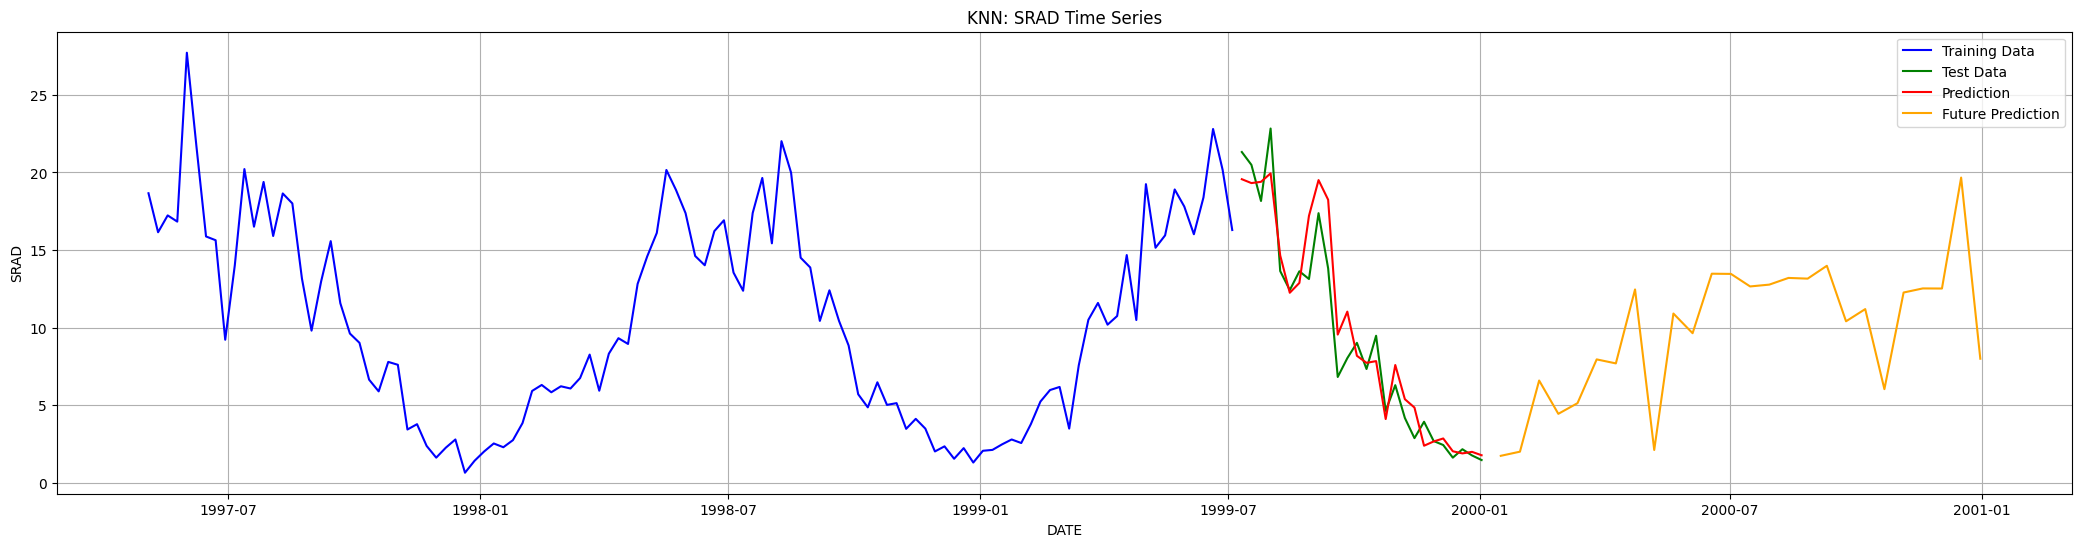

RF Evaluation Metrics:
Mean Absolute Percentage Error: 0.12336739403880982
R2 Score: 0.9735835346864953
Mean Absolute Error: 0.8023912087912108
Mean Squared Error: 1.155220401695453
Root Mean Squared Error: 1.0748117982677028


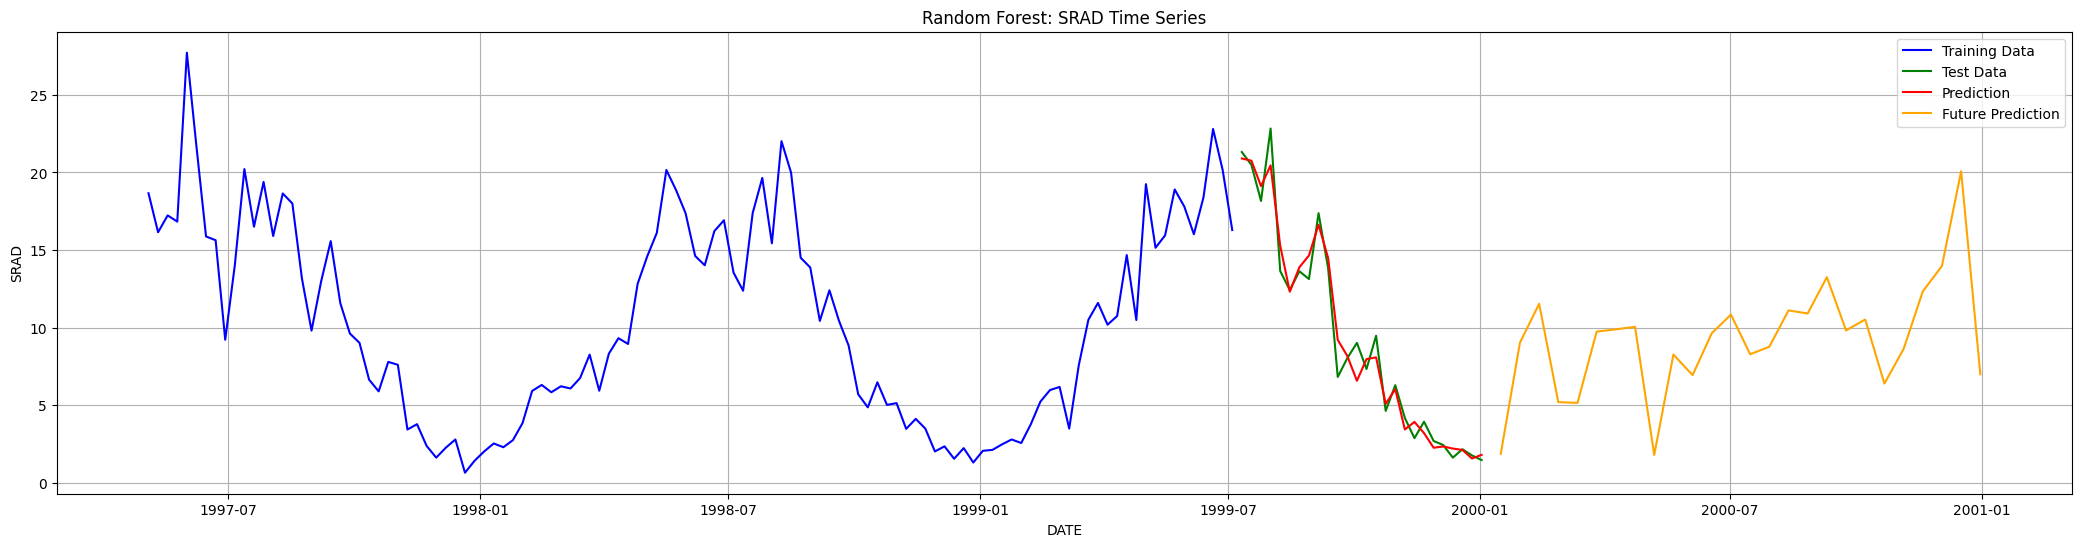

XGB Evaluation Metrics:
Mean Absolute Percentage Error: 0.11680089675463588
R2 Score: 0.971788693810841
Mean Absolute Error: 0.8102458986869223
Mean Squared Error: 1.2337107209999352
Root Mean Squared Error: 1.1107253130274537


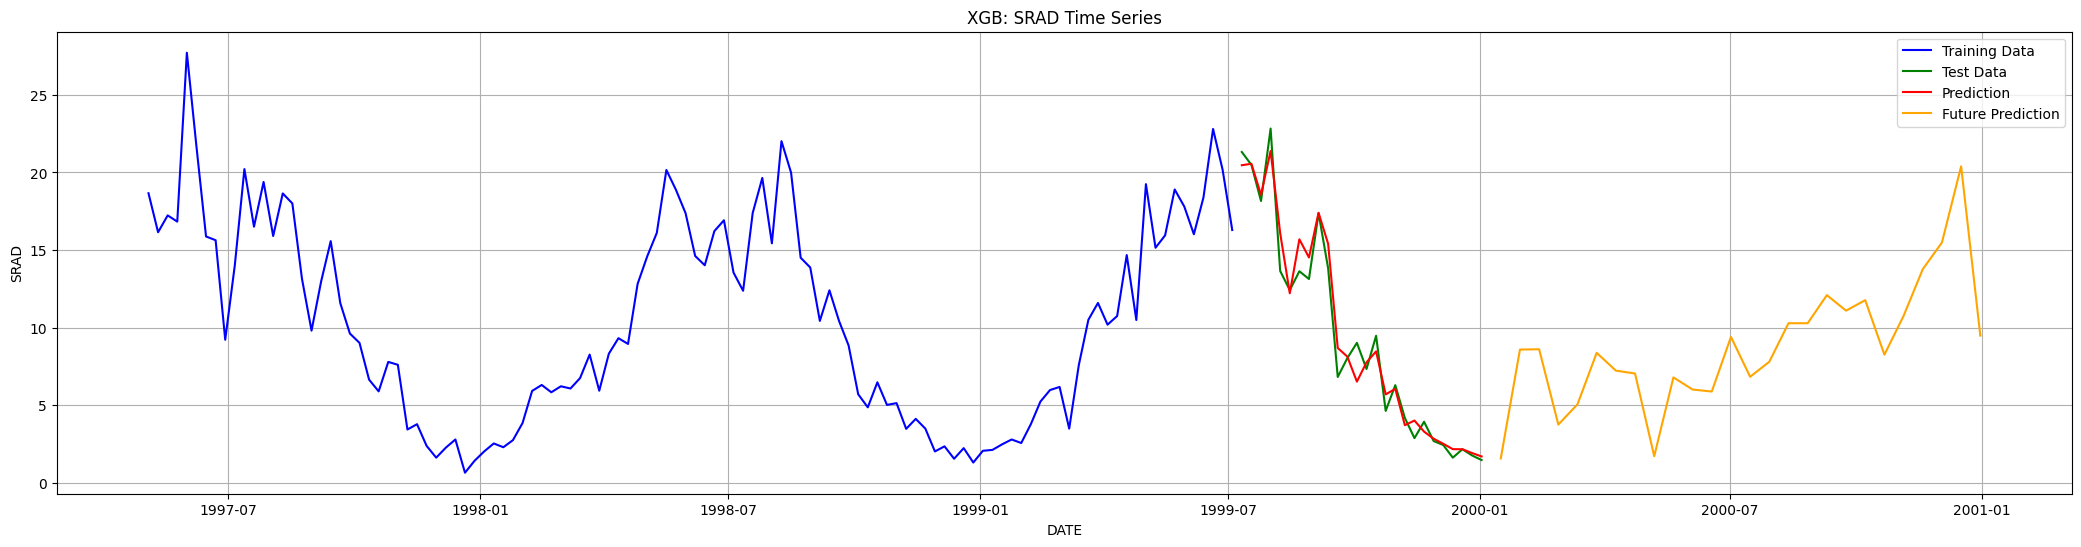

ADABOOST Evaluation Metrics:
Mean Absolute Percentage Error: 0.14672307852420755
R2 Score: 0.9642689404159502
Mean Absolute Error: 0.9685714285714284
Mean Squared Error: 1.5625576138147568
Root Mean Squared Error: 1.2500230453134682


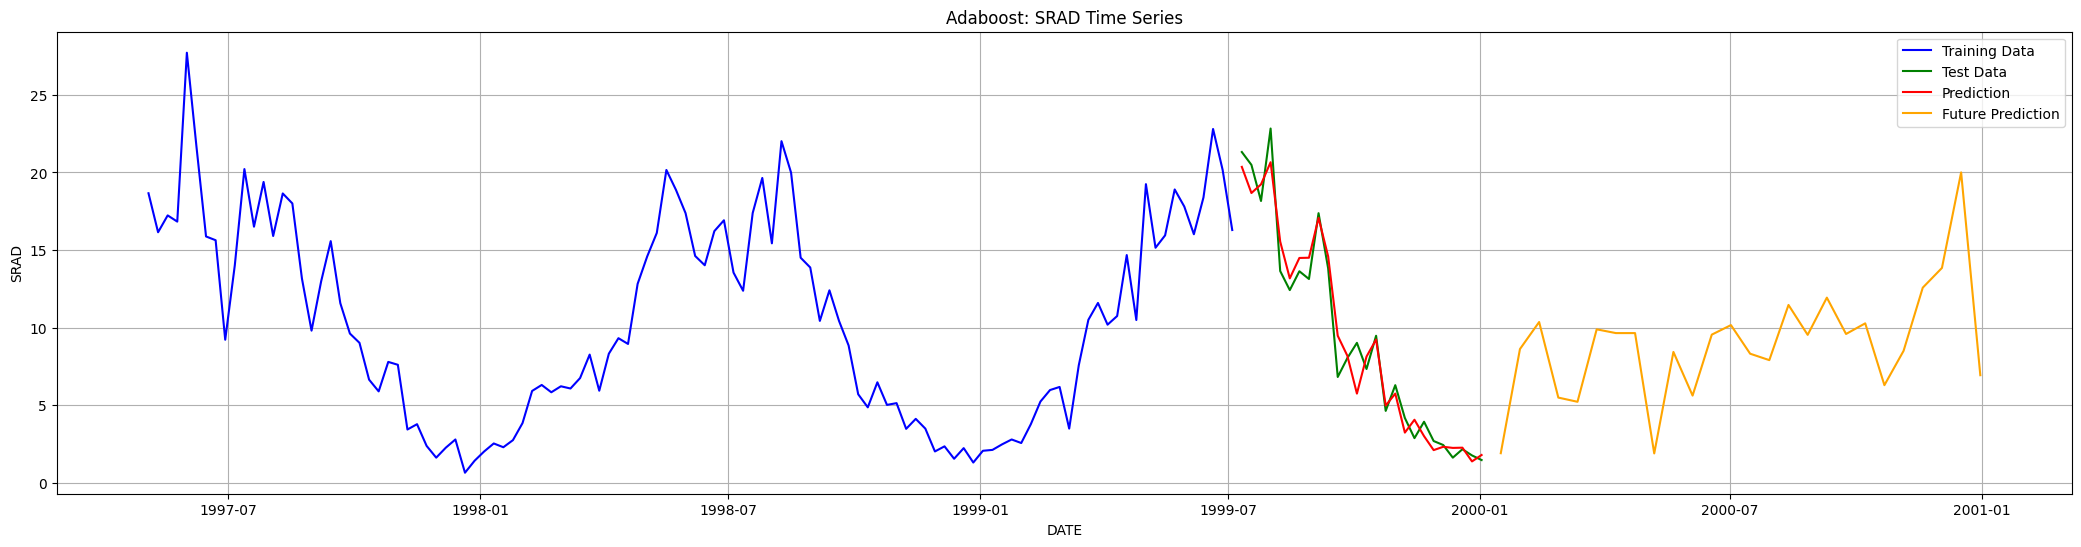

MLP Evaluation Metrics:
Mean Absolute Percentage Error: 0.11695475326011937
R2 Score: 0.9687465394616085
Mean Absolute Error: 0.8395123113107312
Mean Squared Error: 1.3667473982250053
Root Mean Squared Error: 1.1690797227841245


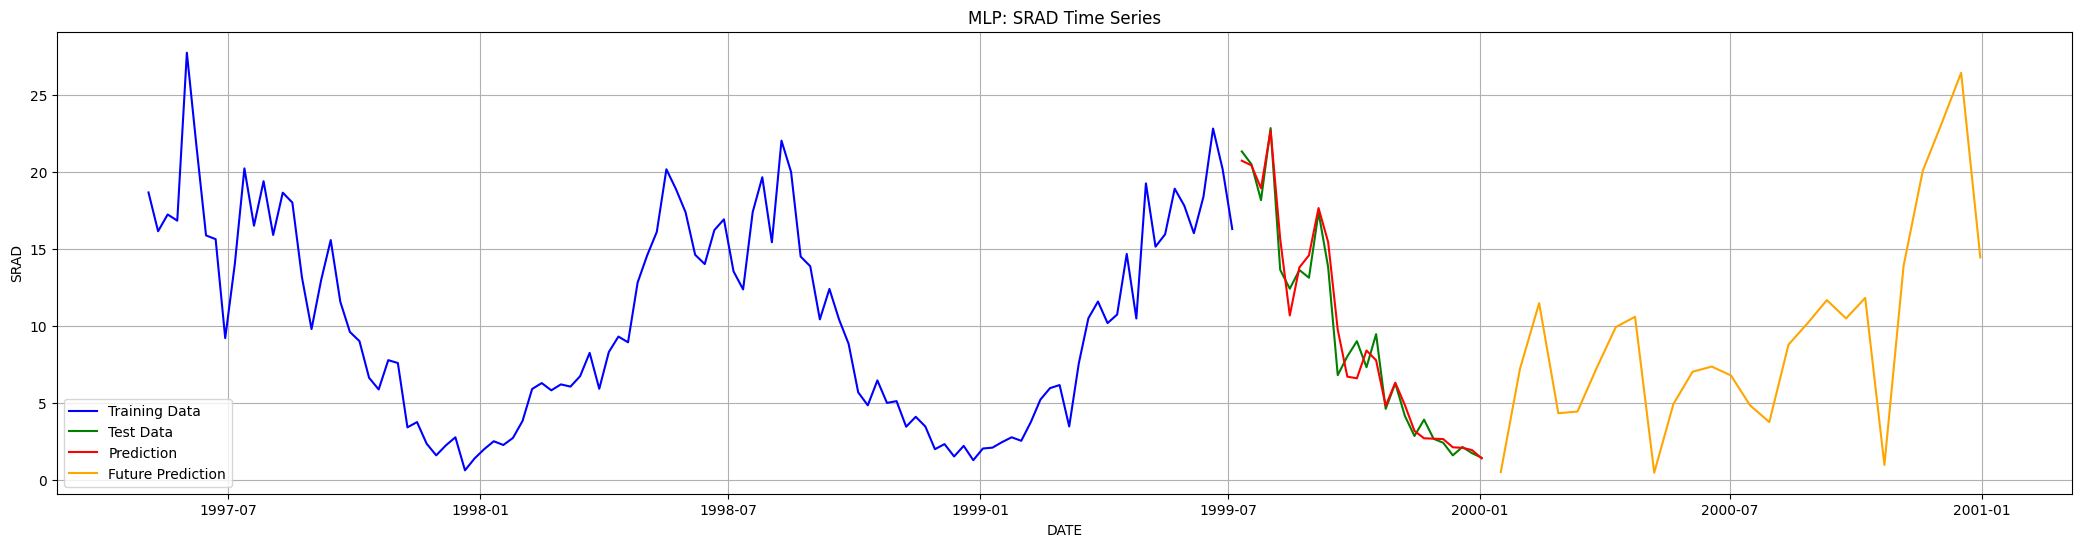

LSTM Evaluation Metrics:
Mean Absolute Percentage Error: 0.12059505962586706
R2 Score: 0.978367413727317
Mean Absolute Error: 0.7872791943707309
Mean Squared Error: 0.9460162329463825
Root Mean Squared Error: 0.9726336581397862


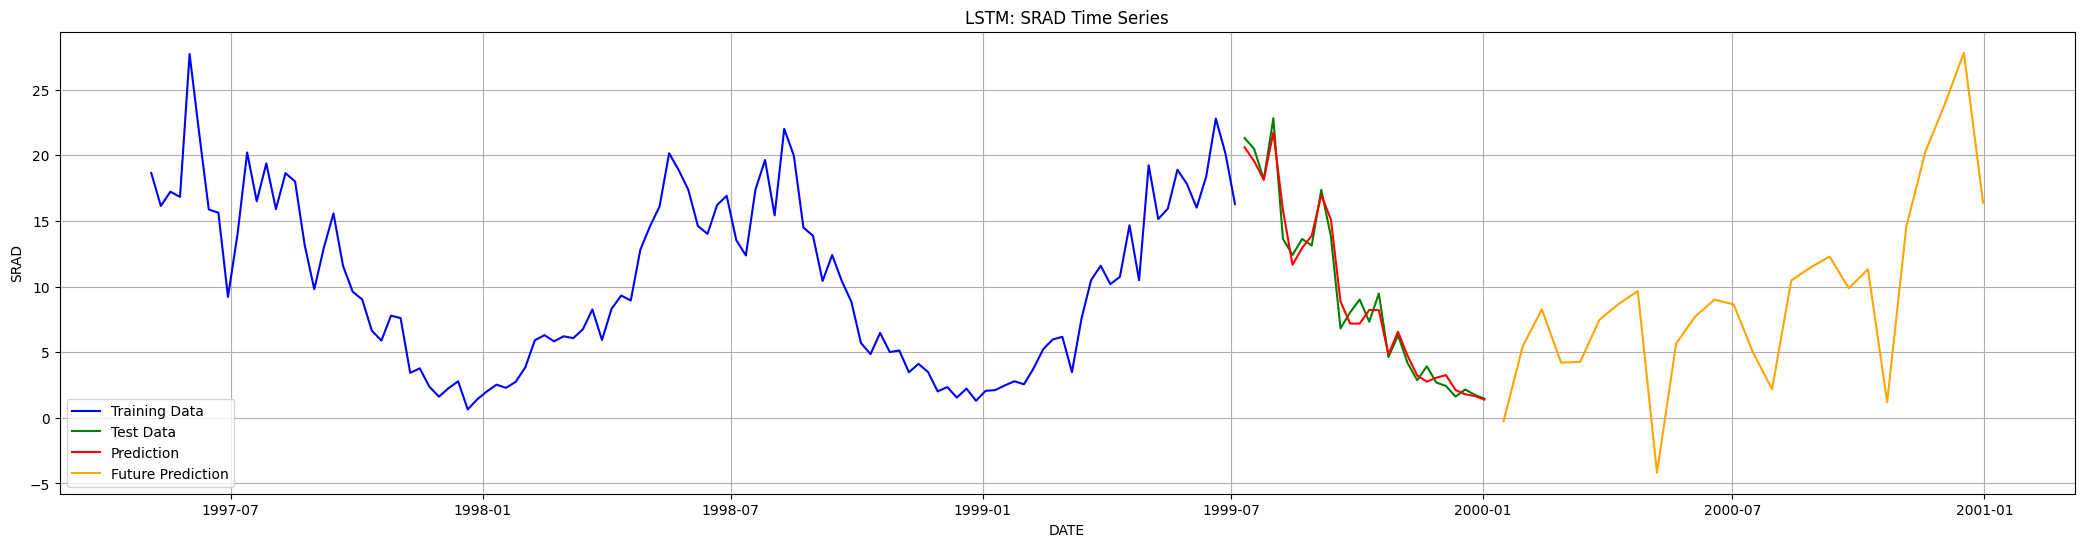

Voting Evaluation Metrics:
Mean Absolute Percentage Error: 0.1133865290161966
R2 Score: 0.9714937695505159
Mean Absolute Error: 0.8295392948380633
Mean Squared Error: 1.2466080756777507
Root Mean Squared Error: 1.116516043627565


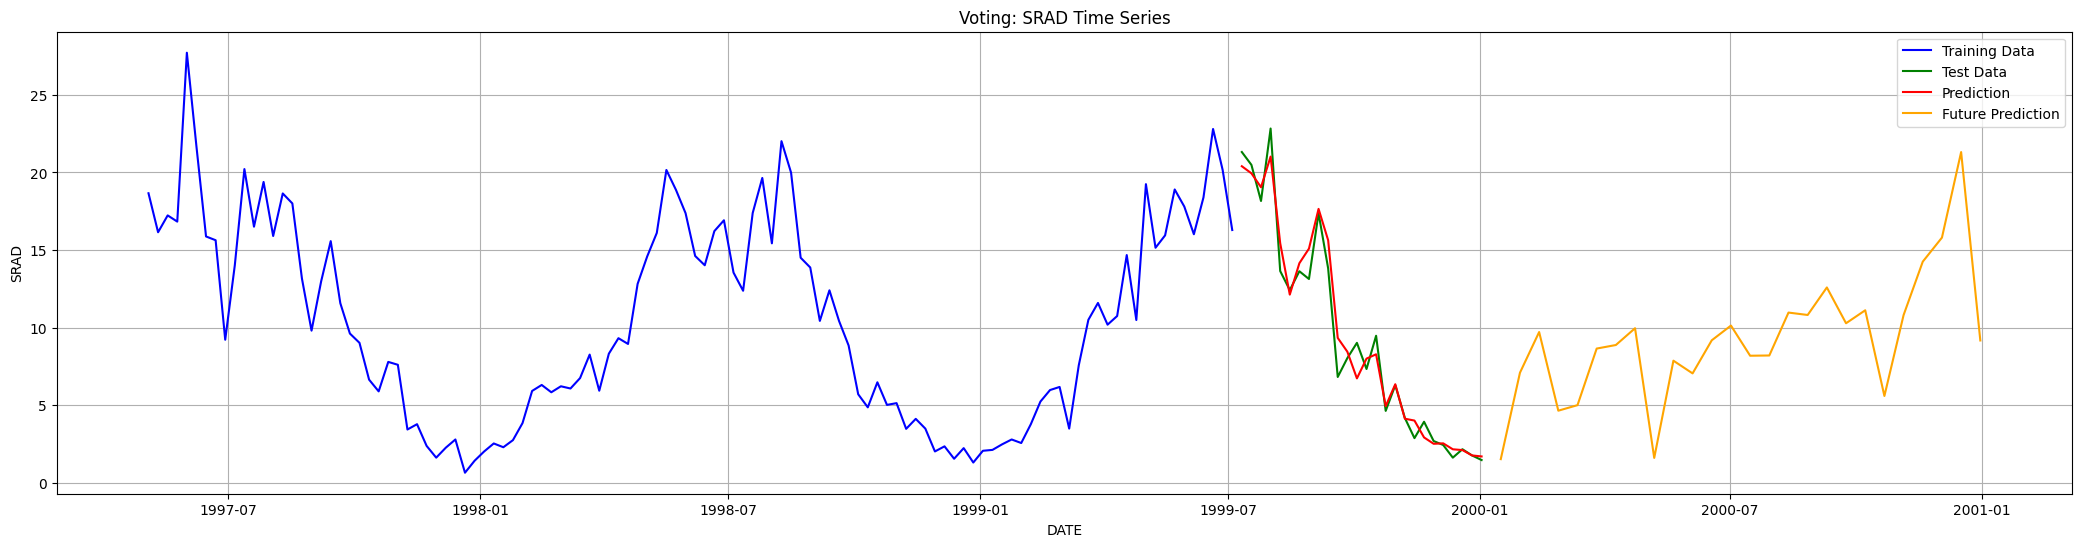

Stacking Evaluation Metrics:
Mean Absolute Percentage Error: 0.12980023283126296
R2 Score: 0.9677177549880149
Mean Absolute Error: 0.881317582417593
Mean Squared Error: 1.411737248257488
Root Mean Squared Error: 1.188165496998414


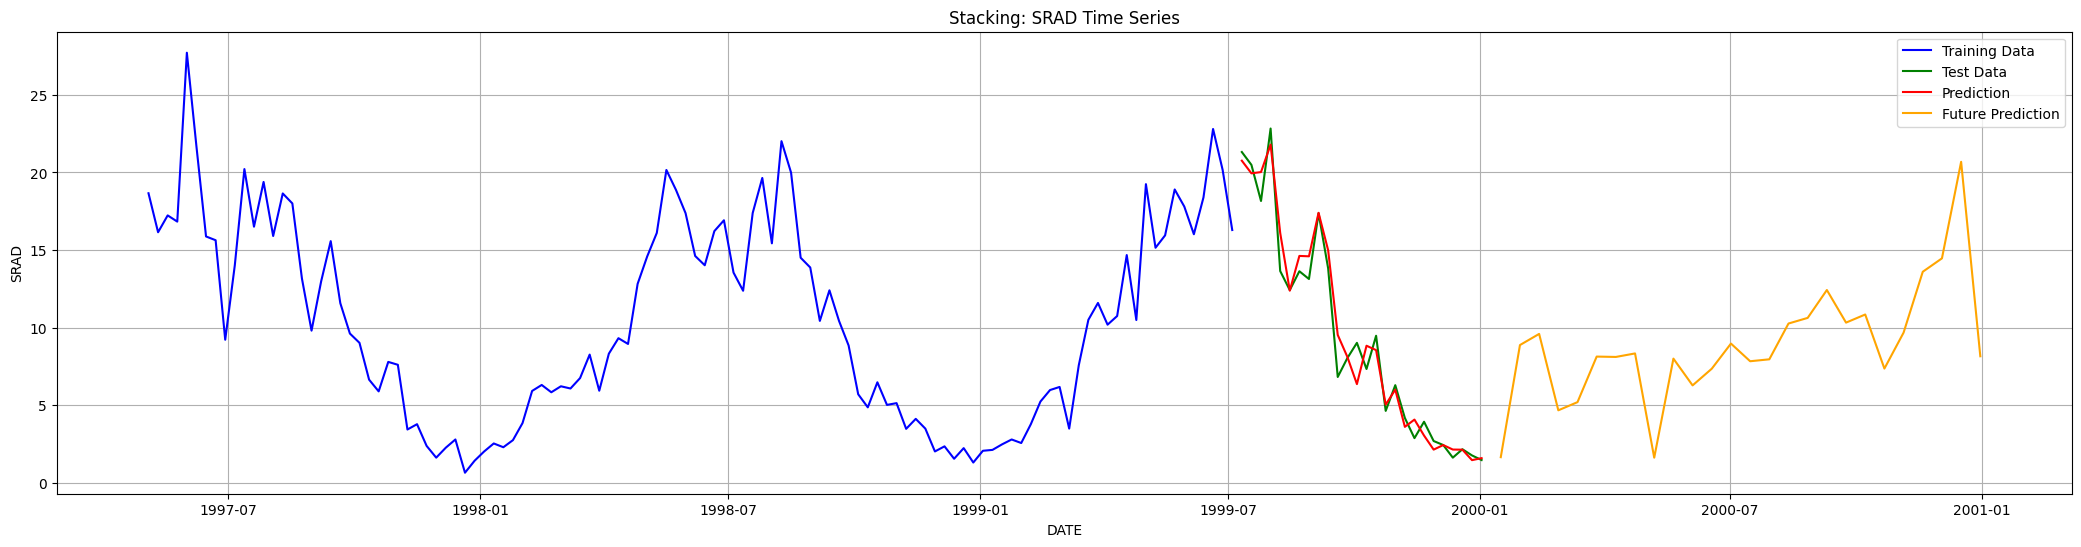

In [21]:
result = [result_predictions_knn, result_predictions_rf, result_predictions_xgb, result_predictions_ada, result_predictions_mlp, result_predictions_lstm, result_predictions_voting, result_predictions_stacking]
final_prediction = [future_predictions_knn, future_predictions_rf, future_predictions_xgb, future_predictions_ada, future_predictions_mlp, future_predictions_lstm, future_predictions_voting, future_predictions_stacking]

for i in range(len(result)):

    train_data = final_data.iloc[:len(final_data)-start, :]
    train_data = train_data[[target, "@DATE"]]

    test_data = final_data.iloc[len(final_data)-start:, :]
    test_data = test_data[[target, "@DATE"]]

    prediction = test_data["@DATE"]
    prediction = pd.DataFrame({"@DATE": prediction, "Prediction": result[i] })
    
    future_predict = future_data["@DATE"]
    future_predict = pd.DataFrame({"@DATE": future_predict, "Prediction": final_prediction[i] })
    
    # Extract the first element from lists in the Prediction column
    prediction["Prediction"] = prediction["Prediction"].apply(lambda x: x[0] if isinstance(x, list) else x)
    
    # Ensure the Prediction column contains numeric values
    prediction["Prediction"] = pd.to_numeric(prediction["Prediction"], errors='coerce')
    
    future_predict["Prediction"] = future_predict["Prediction"].apply(lambda x: x[0] if isinstance(x, list) else x)
    future_predict["Prediction"] = pd.to_numeric(future_predict["Prediction"], errors='coerce')
    
    # Print the model evaluation metrics
    if result[i] == result_predictions_knn:
        print("KNN Evaluation Metrics:")
        
    elif result[i] == result_predictions_rf:
        print("RF Evaluation Metrics:")
    
    elif result[i] == result_predictions_xgb:
        print("XGB Evaluation Metrics:")
        
    elif result[i] == result_predictions_ada:
        print("ADABOOST Evaluation Metrics:")

    elif result[i] == result_predictions_mlp:
        print("MLP Evaluation Metrics:")
        
    elif result[i] == result_predictions_lstm:
        print("LSTM Evaluation Metrics:")
        
    elif result[i] == result_predictions_voting:
        print("Voting Evaluation Metrics:")
        
    elif result[i] == result_predictions_stacking:
        print("Stacking Evaluation Metrics:")
        
    # Now proceed with the evaluation metrics
    y_true = test_data[target]
    y_pred = prediction["Prediction"]

    print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true, y_pred)}")
    print(f"R2 Score: {r2_score(y_true, y_pred)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred)}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred)}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    
    # Plot the training data, test data, predictions, and future predictions
    plt.figure(figsize=(26, 6))
    plt.plot(train_data[2000:]["@DATE"], train_data[2000:][target], label="Training Data", color="blue")
    plt.plot(test_data["@DATE"], test_data[target], label="Test Data", color="green")
    plt.plot(prediction["@DATE"], prediction["Prediction"], label="Prediction", color="red")
    plt.plot(future_predict["@DATE"], future_predict["Prediction"], label="Future Prediction", color="orange")
    
    # Add appropriate title based on the model
    if result[i] == result_predictions_knn:
        plt.title(f"KNN: {target} Time Series")
        
    elif result[i] == result_predictions_rf:
        plt.title(f"Random Forest: {target} Time Series")
    
    elif result[i] == result_predictions_xgb:
        plt.title(f"XGB: {target} Time Series")
        
    elif result[i] == result_predictions_ada:
        plt.title(f"Adaboost: {target} Time Series")

    elif result[i] == result_predictions_mlp:
        plt.title(f"MLP: {target} Time Series")
        
    elif result[i] == result_predictions_lstm:
        plt.title(f"LSTM: {target} Time Series")
        
    elif result[i] == result_predictions_voting:
        plt.title(f"Voting: {target} Time Series")
        
    elif result[i] == result_predictions_stacking:
        plt.title(f"Stacking: {target} Time Series")
    
    plt.xlabel("DATE")
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()
